# Отток клиентов

Техническое задание:

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры (не менее 0.59). Также нужно проанализировать *AUC-ROC*.

В проекте использованы библиотеки pandas, matplotlib, numpy, sklearn. Данные проаназилированы. Отток клиентов предсказан с помощью моделей дерева решений, случайного леса и логистической регрессии. Предсказание идёт как на числовых, так и на категориальных переменных (перекодированы в дихотомические с помощью OHE). В ходе исследования пришлось работать с дисбалансом классов (отток клиентов происходит значительно реже, чем удержание). Отработано взврешивание классов, ресемплинг, изменение порога. На каждом этапе модели сравниваются по F1, accuracy И AUC-ROC.

## Подготовка данных

Импортируем модули, которые нам понадобятся для дальнейшей работы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
import warnings
warnings.simplefilter('ignore')

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

Читаем базу данных.

In [2]:
df_0 = pd.read_csv('Churn.csv', sep= ',')
display(df_0)
df_0.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В предоставленной базе данных 14 столбцов, но только 10 из них будут предикторами: мы не будем использовать номер строки (RowNumber), ID пользователя (CustomerId) и фамилию (Surname), т.к. эти значения уникальны для каждого объекта и не относятся к причинам прекращения пользования услугами банка. Будем работать с таблицей без этих столбцов:

In [3]:
df = df_0.drop(['RowNumber','CustomerId','Surname'], axis=1)

Есть пропуски в переменной длительности пользования услугами банка ('Tenure'), но восстановить их по прочим признакам не представляется возможным, нет ни корреляции, ни какой-либо связи с другими признаками. Заполнить отсутствующие значения 0 мы не можем, т.к. это не верно с точки зрения значения переменной. Оставить пропуски тоже нельзя, т.к. обучаемые модели требуют 100% заполнения данных. В результате эксперимента было обнаружено, что качество модели выше, если использовать только 9091 записей, где есть 100% данных, чем качество модели, в которой не учитывается признак Tenure, поэтому принято решение оставить в базе для анализа только 9091 объектов.

In [4]:
df = df.dropna()
df.shape

(9091, 11)

По прочим характеристикам каждого пользователя мы постараемся предсказать признак остановки обслуживания (Exited).

Столбцы таблицы названы не в соответствии со "snake case", но без пробелом, сочтём это некритичным.

Посмотрим на распределения данных визуально.

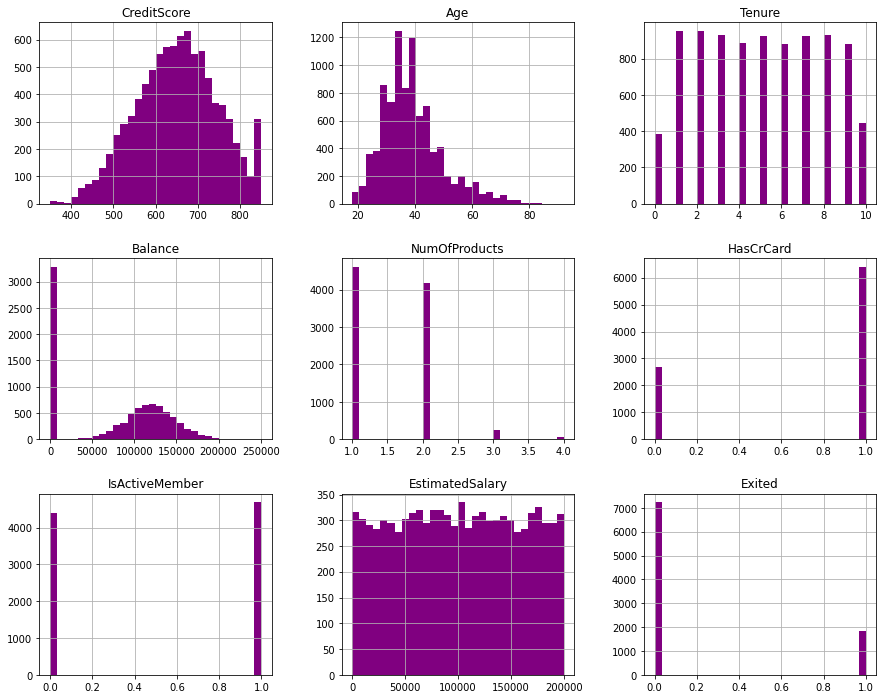

In [5]:
df.hist(
    bins = 30,
    color = 'purple',
    figsize = (15,12))
plt.show()

Добавим распределения текстовых переменных:

In [6]:
print(df['Geography'].value_counts())
df['Gender'].value_counts()

France     4550
Germany    2293
Spain      2248
Name: Geography, dtype: int64


Male      4974
Female    4117
Name: Gender, dtype: int64

Ряд признаков несбалансирован: существенная часть потребителей имеет нулевой баланс, количество потребителей, имеющих более 2 продуктов, можно было бы приравнять к 2, однако подобные перекодировки приведут к потере объема данных и ухудшению модели. Отметим, что баланс классов целевого признака также не соблюдается: предсказывая 100% удержание клиентов, мы будем правы в 4 из 5 случаев. Посмотрим, нет ли мультиколлинеарности между признаками, чтобы исключить те из них, что по сути являются одним и тем же фактором:

In [7]:
df.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182,-0.023950
Age,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037,0.283017
Tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351,0.117218
NumOfProducts,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990,-0.050271
HasCrCard,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136,-0.005411
IsActiveMember,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049,-0.155062
EstimatedSalary,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000,0.016029
Exited,-0.023950,0.283017,-0.016761,0.117218,-0.050271,-0.005411,-0.155062,0.016029,1.000000


Мультиколлинеарности нет, что мы также проверяли на диаграммах рассеяния (pd.plotting.scatter_matrix, не будем загромождать отчёт). Переведём текстовые переменные в дихотомические для удобства работы модели и разделим выборку на 60% учебного массива, 20% валидационного и 20% тестового:

In [8]:
df_ohe = pd.get_dummies(df, drop_first=True)

X = df_ohe.drop(['Exited'], axis=1)
y = df_ohe['Exited']

X_train, X_to_split, y_train, y_to_split = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=12345)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_to_split, y_to_split, test_size=0.5, stratify=y_to_split, random_state=12345)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(9091, 11) (9091,)
(5454, 11) (5454,)
(1818, 11) (1818,)
(1819, 11) (1819,)


Данные готовы для моделирования.

## Исследование задачи

Применим три модели с простыми параметрами и посмотрим на качество.

### Дерево решений:

Построим дерево решений, автоматически подберём лучшие параметры максимальной глубины дерева, минимального объёма выборки на концах "ветвей" и на "узлах".

accuracy: 0.87
f1_score: 0.60
AUC-ROC: 0.85


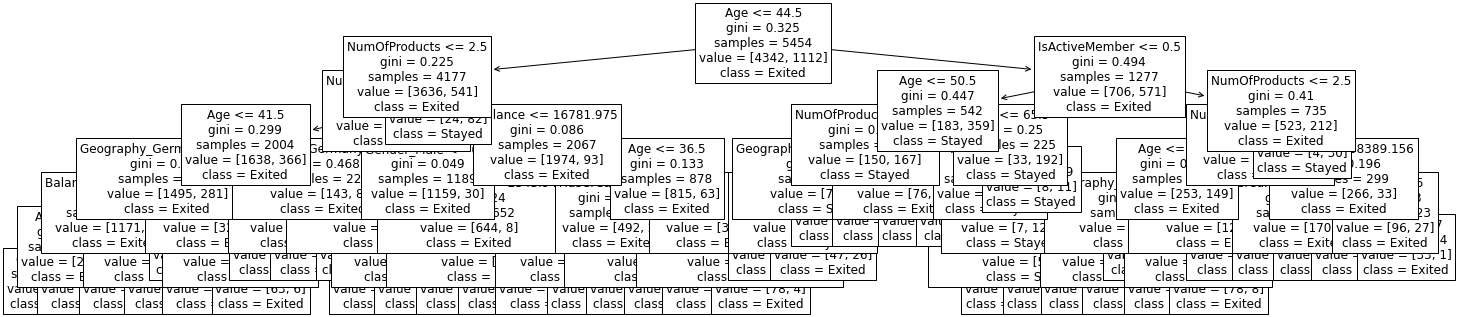

In [9]:
best_depth_tree_simple=[]
for depth in np.arange(1, 50, 1):
    model = DecisionTreeClassifier(
        random_state=12345, max_depth=depth)
    model.fit(X_train, y_train)
    best_depth_tree_simple.append([f1_score(y_valid, model.predict(X_valid)), depth])
best_depth_tree_simple = pd.Series(best_depth_tree_simple).max()[1]


best_split_simple=[]
for split in np.arange(2, 300, 10):
    model = DecisionTreeClassifier(
        random_state=12345, max_depth=best_depth_tree_simple, min_samples_split=split)
    model.fit(X_train, y_train)
    best_split_simple.append([f1_score(y_valid, model.predict(X_valid)), split])
best_split_simple = pd.Series(best_split_simple).max()[1]

best_leaf_simple=[]
for leaf in np.arange(2, 300, 10):
    model = DecisionTreeClassifier(
        random_state=12345, max_depth=best_depth_tree_simple, min_samples_split=best_split_simple, min_samples_leaf=leaf)
    model.fit(X_train, y_train)
    best_leaf_simple.append([f1_score(y_valid, model.predict(X_valid)), leaf])
best_leaf_simple = pd.Series(best_leaf_simple).max()[1]


model_tree = DecisionTreeClassifier(
    random_state=12345,
    max_depth=best_depth_tree_simple,
    min_samples_split=best_split_simple,
    min_samples_leaf=best_leaf_simple)
model_tree.fit(X_train, y_train)
predictions_valid = model_tree.predict(X_valid)
print('accuracy: {:.2f}'.format(accuracy_score(y_valid, predictions_valid)))
print('f1_score: {:.2f}'.format(f1_score(y_valid, predictions_valid)))
print('AUC-ROC: {:.2f}'.format(roc_auc_score(y_valid, model_tree.predict_proba(X_valid)[:, 1])))
plt.figure(figsize=(25, 5))
tree.plot_tree(model_tree, feature_names=X.columns, class_names = ['Ехited', 'Stayed'], fontsize=12)
plt.show()

Похоже, что возраст, количество используемых продуктов и активность пользователя важные признаки - они стоят на верхних узлах дерева. Они же обладают высокой корреляцией с целевым признаком.

Качество полученной модели сравнимо с монеткой, у которой вероятность выпадения одной стороны равна частоте ухода клиентов от банка, то есть эта модель предсказывает уход клиентов практически случайно.

### Случайный лес:

Построим случайный лес, автоматически подберём лучшие параметры максимальной глубины деревьев и их количества

In [10]:
best_est_simple=[]
for est in np.arange(50, 251, 10):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(X_train, y_train)
    best_est_simple.append([f1_score(y_valid, model.predict(X_valid)), est])
best_est_simple = pd.Series(best_est_simple).max()[1]

best_depth_simple=[]
for depth in np.arange(1, 20, 1):
    model = RandomForestClassifier(random_state=12345, n_estimators=best_est_simple, max_depth=depth)
    model.fit(X_train, y_train)
    best_depth_simple.append([f1_score(y_valid, model.predict(X_valid)), depth])
best_depth_simple = pd.Series(best_depth_simple).max()[1]

model_forest = RandomForestClassifier(random_state=12345, n_estimators=best_est_simple, max_depth=best_depth_simple)
model_forest.fit(X_train, y_train)
predictions_valid = model_forest.predict(X_valid)
print('accuracy: {:.2f}'.format(accuracy_score(y_valid, predictions_valid)))
print('f1_score: {:.2f}'.format(f1_score(y_valid, predictions_valid)))
print('AUC-ROC: {:.2f}'.format(roc_auc_score(y_valid, model_forest.predict_proba(X_valid)[:, 1])))

accuracy: 0.87
f1_score: 0.61
AUC-ROC: 0.87


Показатели качества модели лучше, но все равно всё ещё близки к случайной.

### Логистическая регрессия:

In [11]:
model_regression = LogisticRegression(random_state=12345, solver='liblinear')
model_regression.fit(X_train, y_train)
predictions_valid = model_regression.predict(X_valid)
print('accuracy: {:.2f}'.format(model_regression.score(X_valid, y_valid)))
print('f1_score: {:.2f}'.format(f1_score(y_valid, predictions_valid)))
print('AUC-ROC: {:.2f}'.format(roc_auc_score(y_valid, model_regression.predict_proba(X_valid)[:, 1])))

accuracy: 0.79
f1_score: 0.08
AUC-ROC: 0.68


Качество хуже, и сменой гиперпараметров дерева решений и случайного леса существенно повысить её не удастся, необходимо преобразовать саму выборку.

Соберём полученные показатели качества в одну таблицу:

In [12]:
simple_models= pd.DataFrame({'metrics': ['accuracy_simple', 'f1_score_simple', 'AUC-ROC_simple'],
              'tree': [accuracy_score(y_valid, model_tree.predict(X_valid)),
                       f1_score(y_valid, model_tree.predict(X_valid)),
                       roc_auc_score(y_valid, model_tree.predict_proba(X_valid)[:, 1])],
              'forest': [accuracy_score(y_valid, model_forest.predict(X_valid)),
                       f1_score(y_valid, model_forest.predict(X_valid)),
                       roc_auc_score(y_valid, model_forest.predict_proba(X_valid)[:, 1])],
              'log_regression': [model_regression.score(X_valid, y_valid),
                       f1_score(y_valid, model_regression.predict(X_valid)),
                       roc_auc_score(y_valid, model_regression.predict_proba(X_valid)[:, 1])]})
simple_models

,metrics,tree,forest,log_regression
0,accuracy_simple,0.865787,0.869087,0.787129
1,f1_score_simple,0.600000,0.611111,0.076372
2,AUC-ROC_simple,0.852667,0.865979,0.682272


Вывод: нам не удалось достингуть требуемого качества модели (F1-мера должна быть не менее 0,59). Частота возниновения события "клиент ушёл" существенно ниже частоты события "клиент остался", что вызывает дисбаланс классов. Необходимо использовать несколько способов борьбы с ним.

## Борьба с дисбалансом

### Взвешивание классов

Применим данный метод сразу к трём моделям, автоматически подобрав наилучшие параметры:

In [13]:
best_depth_tree=[]
for depth in np.arange(1, 50, 1):
    model = DecisionTreeClassifier(
        random_state=12345, max_depth=depth,
        class_weight='balanced')
    model.fit(X_train, y_train)
    best_depth_tree.append([f1_score(y_valid, model.predict(X_valid)), depth])
best_depth_tree = pd.Series(best_depth_tree).max()[1]

best_split=[]
for split in np.arange(2, 300, 10):
    model = DecisionTreeClassifier(
        random_state=12345, max_depth=best_depth_tree, min_samples_split=split,
        class_weight='balanced')
    model.fit(X_train, y_train)
    best_split.append([f1_score(y_valid, model.predict(X_valid)), split])
best_split = pd.Series(best_split).max()[1]

best_leaf=[]
for leaf in np.arange(2, 300, 10):
    model = DecisionTreeClassifier(
        random_state=12345, max_depth=best_depth_tree, min_samples_split=best_split, min_samples_leaf=leaf,
        class_weight='balanced')
    model.fit(X_train, y_train)
    best_leaf.append([f1_score(y_valid, model.predict(X_valid)), leaf])
best_leaf = pd.Series(best_leaf).max()[1]

model_tree = DecisionTreeClassifier(
    random_state=12345,
    max_depth=best_depth_tree,
    min_samples_split=best_split,
    min_samples_leaf=best_leaf,
    class_weight='balanced')
model_tree.fit(X_train, y_train)


best_est_weighted=[]
for est in np.arange(50, 251, 10):
    model = RandomForestClassifier(
        random_state=12345, n_estimators=est, class_weight='balanced')
    model.fit(X_train, y_train)
    best_est_weighted.append([f1_score(y_valid, model.predict(X_valid)), est])
best_est_weighted = pd.Series(best_est_weighted).max()[1]

best_depth_weighted=[]
for depth in np.arange(1, 20, 1):
    model = RandomForestClassifier(
        random_state=12345, n_estimators=best_est_weighted, max_depth=depth, class_weight='balanced')
    model.fit(X_train, y_train)
    best_depth_weighted.append([f1_score(y_valid, model.predict(X_valid)), depth])
best_depth_weighted = pd.Series(best_depth_weighted).max()[1]

model_forest = RandomForestClassifier(
    random_state=12345, n_estimators=best_est_weighted, max_depth=best_depth_weighted, class_weight='balanced')
model_forest.fit(X_train, y_train)


model_regression = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_regression.fit(X_train, y_train)

weighted_models = pd.DataFrame({'metrics': ['accuracy_weighted', 'f1_score_weighted', 'AUC-ROC_weighted'],
              'tree': [accuracy_score(y_valid, model_tree.predict(X_valid)),
                       f1_score(y_valid, model_tree.predict(X_valid)),
                       roc_auc_score(y_valid, model_tree.predict_proba(X_valid)[:, 1])],
              'forest': [accuracy_score(y_valid, model_forest.predict(X_valid)),
                       f1_score(y_valid, model_forest.predict(X_valid)),
                       roc_auc_score(y_valid, model_forest.predict_proba(X_valid)[:, 1])],
              'log_regression': [model_regression.score(X_valid, y_valid),
                       f1_score(y_valid, model_regression.predict(X_valid)),
                       roc_auc_score(y_valid, model_regression.predict_proba(X_valid)[:, 1])]})
all_models = weighted_models.merge(simple_models, how = 'outer')
all_models

,metrics,tree,forest,log_regression
0,accuracy_weighted,0.771727,0.849285,0.700770
1,f1_score_weighted,0.591133,0.652284,0.498155
2,AUC-ROC_weighted,0.852618,0.876085,0.784935
3,accuracy_simple,0.865787,0.869087,0.787129
4,f1_score_simple,0.600000,0.611111,0.076372
5,AUC-ROC_simple,0.852667,0.865979,0.682272


В целом модель стала лучше предсказывать уход клиентов, но можно попробовать ещё улучшить модели. Существенно повысились F1 мера и AUC-ROC логистической регрессии.

### Изменение пропорции ушедших и оставшихся клиентов

Т.к. клиенты уходят реже, чем остаются, можно увеличить их присутствие в выборке, искусственно умножив их число на 2, а число оставшихся клиентов сократить вдвое, так размеры этих групп станут сопоставимы.

In [14]:
X_zeros = X_train[y == 0]
X_ones = X_train[y == 1]
y_zeros = y_train[y == 0]
y_ones = y_train[y == 1]

X_resampled = pd.concat([X_zeros.sample(frac=0.5, random_state=12345)] + [X_ones] * 2)
y_resampled = pd.concat([y_zeros.sample(frac=0.5, random_state=12345)] + [y_ones] * 2)
    
X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=12345)

best_depth_tree=[]
for depth in np.arange(1, 50, 1):
    model = DecisionTreeClassifier(
        random_state=12345, max_depth=depth)
    model.fit(X_resampled, y_resampled)
    best_depth_tree.append([f1_score(y_valid, model.predict(X_valid)), depth])
best_depth_tree = pd.Series(best_depth_tree).max()[1]

best_split=[]
for split in np.arange(2, 300, 10):
    model = DecisionTreeClassifier(
        random_state=12345, max_depth=best_depth_tree, min_samples_split=split)
    model.fit(X_resampled, y_resampled)
    best_split.append([f1_score(y_valid, model.predict(X_valid)), split])
best_split = pd.Series(best_split).max()[1]

best_leaf=[]
for leaf in np.arange(2, 300, 10):
    model = DecisionTreeClassifier(
        random_state=12345, max_depth=best_depth_tree, min_samples_split=best_split, min_samples_leaf=leaf)
    model.fit(X_resampled, y_resampled)
    best_leaf.append([f1_score(y_valid, model.predict(X_valid)), leaf])
best_leaf = pd.Series(best_leaf).max()[1]

model_tree = DecisionTreeClassifier(
    random_state=12345,
    max_depth=best_depth_tree,
    min_samples_split=best_split,
    min_samples_leaf=best_leaf)
model_tree.fit(X_resampled, y_resampled)


best_est=[]
for est in np.arange(50, 251, 10):
    model = RandomForestClassifier(
        random_state=12345, n_estimators=est)
    model.fit(X_resampled, y_resampled)
    best_est.append([f1_score(y_valid, model.predict(X_valid)), est])
best_est = pd.Series(best_est).max()[1]

best_depth=[]
for depth in np.arange(1, 20, 1):
    model = RandomForestClassifier(
        random_state=12345, n_estimators=best_est, max_depth=depth)
    model.fit(X_resampled, y_resampled)
    best_depth.append([f1_score(y_valid, model.predict(X_valid)), depth])
best_depth = pd.Series(best_depth).max()[1]

model_forest = RandomForestClassifier(
    random_state=12345, n_estimators=best_est, max_depth=best_depth)
model_forest.fit(X_resampled, y_resampled)


model_regression = LogisticRegression(random_state=12345, solver='liblinear')
model_regression.fit(X_resampled, y_resampled)


resampled_models = pd.DataFrame({'metrics': ['accuracy_resampled', 'f1_score_resampled', 'AUC-ROC_resampled'],
              'tree': [accuracy_score(y_valid, model_tree.predict(X_valid)),
                       f1_score(y_valid, model_tree.predict(X_valid)),
                       roc_auc_score(y_valid, model_tree.predict_proba(X_valid)[:, 1])],
              'forest': [accuracy_score(y_valid, model_forest.predict(X_valid)),
                       f1_score(y_valid, model_forest.predict(X_valid)),
                       roc_auc_score(y_valid, model_forest.predict_proba(X_valid)[:, 1])],
              'log_regression': [model_regression.score(X_valid, y_valid),
                       f1_score(y_valid, model_regression.predict(X_valid)),
                       roc_auc_score(y_valid, model_regression.predict_proba(X_valid)[:, 1])]})
all_models = all_models.merge(resampled_models, how = 'outer')
all_models

,metrics,tree,forest,log_regression
0,accuracy_weighted,0.771727,0.849285,0.700770
1,f1_score_weighted,0.591133,0.652284,0.498155
2,AUC-ROC_weighted,0.852618,0.876085,0.784935
3,accuracy_simple,0.865787,0.869087,0.787129
4,f1_score_simple,0.600000,0.611111,0.076372
5,AUC-ROC_simple,0.852667,0.865979,0.682272
6,accuracy_resampled,0.769527,0.835534,0.657316
7,f1_score_resampled,0.578894,0.641056,0.459670
8,AUC-ROC_resampled,0.849898,0.871197,0.729272


Существенных улучшений не произошло, в основном показатели ухудшились. Не будем использовать увеличение частоты редких классов и уменьшение частых.

### Изменение порога

В целевой переменной граница, где начинается отрицательный (клиент остался) и заканчивается положительный (клиент ушёл) класс, далека от 0,5. Найдём порог, для которого мера F1 принимает максимальное значение, и сообщим его модели. Дерево решений (возьмём лучшие параметры модели дерева решений из п 2.1):

In [15]:
model_tree = DecisionTreeClassifier(
    random_state=12345,
    max_depth=best_depth_tree_simple,
    min_samples_split=best_split_simple,
    min_samples_leaf=best_leaf_simple)
model_tree.fit(X_train, y_train)

for threshold in np.arange(0, 1, 0.05):
    predicted_valid = model_tree.predict_proba(X_valid)[:, 1] > threshold
    f1 = f1_score(y_valid, predicted_valid)
    
    print("Порог = {:.2f} | F1 = {:.2f}".format(threshold, f1))

Порог = 0.00 | F1 = 0.34
Порог = 0.05 | F1 = 0.41
Порог = 0.10 | F1 = 0.56
Порог = 0.15 | F1 = 0.58
Порог = 0.20 | F1 = 0.58
Порог = 0.25 | F1 = 0.59
Порог = 0.30 | F1 = 0.60
Порог = 0.35 | F1 = 0.61
Порог = 0.40 | F1 = 0.61
Порог = 0.45 | F1 = 0.60
Порог = 0.50 | F1 = 0.60
Порог = 0.55 | F1 = 0.60
Порог = 0.60 | F1 = 0.56
Порог = 0.65 | F1 = 0.53
Порог = 0.70 | F1 = 0.53
Порог = 0.75 | F1 = 0.50
Порог = 0.80 | F1 = 0.37
Порог = 0.85 | F1 = 0.29
Порог = 0.90 | F1 = 0.22
Порог = 0.95 | F1 = 0.22


Здесь F1-мера максимальна на пороге в 0.4. Случайный лес:

In [16]:
model_forest = RandomForestClassifier(
    random_state=12345, 
    n_estimators=best_est_simple, 
    max_depth=best_depth_simple)
model_forest.fit(X_train, y_train)

for threshold in np.arange(0, 1, 0.05):
    predicted_valid = model_forest.predict_proba(X_valid)[:, 1] > threshold
    f1 = f1_score(y_valid, predicted_valid)
    
    print("Порог = {:.2f} | F1 = {:.3f}".format(threshold, f1))

Порог = 0.00 | F1 = 0.361
Порог = 0.05 | F1 = 0.436
Порог = 0.10 | F1 = 0.496
Порог = 0.15 | F1 = 0.544
Порог = 0.20 | F1 = 0.586
Порог = 0.25 | F1 = 0.609
Порог = 0.30 | F1 = 0.640
Порог = 0.35 | F1 = 0.639
Порог = 0.40 | F1 = 0.642
Порог = 0.45 | F1 = 0.637
Порог = 0.50 | F1 = 0.611
Порог = 0.55 | F1 = 0.599
Порог = 0.60 | F1 = 0.545
Порог = 0.65 | F1 = 0.498
Порог = 0.70 | F1 = 0.436
Порог = 0.75 | F1 = 0.395
Порог = 0.80 | F1 = 0.321
Порог = 0.85 | F1 = 0.232
Порог = 0.90 | F1 = 0.107
Порог = 0.95 | F1 = 0.032


Здесь следует задать порог 0.4. И логистическая регрессия:

In [17]:
model_regression = LogisticRegression(random_state=12345, solver='liblinear')
model_regression.fit(X_train, y_train)

for threshold in np.arange(0, 1, 0.05):
    predicted_valid = model_regression.predict_proba(X_valid)[:, 1] > threshold
    f1 = f1_score(y_valid, predicted_valid)
    
    print("Порог = {:.2f} | F1 = {:.2f}".format(threshold, f1))

Порог = 0.00 | F1 = 0.34
Порог = 0.05 | F1 = 0.34
Порог = 0.10 | F1 = 0.36
Порог = 0.15 | F1 = 0.39
Порог = 0.20 | F1 = 0.41
Порог = 0.25 | F1 = 0.41
Порог = 0.30 | F1 = 0.39
Порог = 0.35 | F1 = 0.33
Порог = 0.40 | F1 = 0.24
Порог = 0.45 | F1 = 0.15
Порог = 0.50 | F1 = 0.08
Порог = 0.55 | F1 = 0.04
Порог = 0.60 | F1 = 0.02
Порог = 0.65 | F1 = 0.01
Порог = 0.70 | F1 = 0.00
Порог = 0.75 | F1 = 0.00
Порог = 0.80 | F1 = 0.00
Порог = 0.85 | F1 = 0.00
Порог = 0.90 | F1 = 0.00
Порог = 0.95 | F1 = 0.00


Здесь максимальные F1 при пороге 0.2. Применим новые пороги к модели:

In [18]:
model_tree = DecisionTreeClassifier(
    random_state=12345,
    max_depth=best_depth_tree_simple,
    min_samples_split=best_split_simple,
    min_samples_leaf=best_leaf_simple)
model_tree.fit(X_train, y_train)

model_forest = RandomForestClassifier(
    random_state=12345, 
    n_estimators=best_est_simple, 
    max_depth=best_depth_simple)
model_forest.fit(X_train, y_train)
model_forest.fit(X_train, y_train)

model_regression = LogisticRegression(random_state=12345, solver='liblinear')
model_regression.fit(X_train, y_train)

changed_threshold_models = pd.DataFrame({'metrics': ['accuracy_changed_threshold',
                                                     'f1_score_changed_threshold',
                                                     'AUC-ROC_changed_threshold'],
              'tree': [accuracy_score(y_valid, model_tree.predict_proba(X_valid)[:, 1] > 0.4),
                       f1_score(y_valid, model_tree.predict_proba(X_valid)[:, 1] > 0.4),
                       roc_auc_score(y_valid, model_tree.predict_proba(X_valid)[:, 1] > 0.4)],
              'forest': [accuracy_score(y_valid, model_forest.predict_proba(X_valid)[:, 1] > 0.4),
                       f1_score(y_valid, model_forest.predict_proba(X_valid)[:, 1] > 0.4),
                       roc_auc_score(y_valid, model_forest.predict_proba(X_valid)[:, 1] > 0.4)],
              'log_regression': [model_regression.score(X_valid, model_regression.predict_proba(X_valid)[:, 1] > 0.2),
                       f1_score(y_valid, model_regression.predict_proba(X_valid)[:, 1] > 0.2),
                       roc_auc_score(y_valid, model_regression.predict_proba(X_valid)[:, 1] > 0.2)]})
all_models = all_models.merge(changed_threshold_models, how = 'outer')
all_models

,metrics,tree,forest,log_regression
0,accuracy_weighted,0.771727,0.849285,0.700770
1,f1_score_weighted,0.591133,0.652284,0.498155
2,AUC-ROC_weighted,0.852618,0.876085,0.784935
3,accuracy_simple,0.865787,0.869087,0.787129
4,f1_score_simple,0.600000,0.611111,0.076372
5,AUC-ROC_simple,0.852667,0.865979,0.682272
6,accuracy_resampled,0.769527,0.835534,0.657316
7,f1_score_resampled,0.578894,0.641056,0.459670
8,AUC-ROC_resampled,0.849898,0.871197,0.729272
9,accuracy_changed_threshold,0.863036,0.862486,0.566007


Так мы смогли улучшить показатели модели логистической регрессии, однако лучшие показатели осталисьу модели Случайный лес с параметром взвешенных классов. Для данной модели изменение порога не повысило метрики F1 и AUC-ROC.

### Определение ключевых параметров успешной модели

Итак, наилучшая модель - случайный лес. Определим наиболее успешные параметры:

In [19]:
print('Оптимальное количество estimators:', best_est_weighted)
print('Оптимальная глубина:', best_depth_weighted)

Оптимальное количество estimators: 150
Оптимальная глубина: 9


In [20]:
model_forest = RandomForestClassifier(
    random_state=12345,
    n_estimators=best_est_weighted,
    max_depth=best_depth_weighted,
    class_weight='balanced')
model_forest.fit(X_train, y_train)
predictions_valid = model_forest.predict(X_valid)
print('accuracy:', accuracy_score(y_valid, predictions_valid),
      'F1:', f1_score(y_valid, predictions_valid),
      'AUC-ROC:', roc_auc_score(y_valid, model_forest.predict_proba(X_valid)[:, 1]))

accuracy: 0.8492849284928493 F1: 0.652284263959391 AUC-ROC: 0.876085292183661


## Тестирование модели

Проверим модель случайного леса на тестовом наборе данных.

In [21]:
predictions_test = model_forest.predict(X_test)
print('accuracy:', accuracy_score(y_test, predictions_test),
      'F1:', f1_score(y_test, predictions_test),
      'AUC-ROC:', roc_auc_score(y_test, model_forest.predict_proba(X_test)[:, 1]))

accuracy: 0.8361737218251787 F1: 0.6005361930294906 AUC-ROC: 0.8502405027475392


Дообучим выбранную модель случайного леса на увеличенной тестовой выборке, объединив тестовую и валидационную выборку и проверим её работу на тестовой выборке.

In [22]:
X_enlarged = X_train.append(X_valid)
y_enlarged = y_train.append(y_valid)

model_forest_reeducated = RandomForestClassifier(random_state=12345,
                                                 n_estimators=210,
                                                 max_depth=11,
                                                 class_weight='balanced')
model_forest_reeducated.fit(X_enlarged, y_enlarged)
predictions_test = model_forest_reeducated.predict(X_test)
print('accuracy:', accuracy_score(y_test, predictions_test),
      'F1:', f1_score(y_test, predictions_test),
      'AUC-ROC:', roc_auc_score(y_test, model_forest.predict_proba(X_test)[:, 1]))

accuracy: 0.845519516217702 F1: 0.6036671368124118 AUC-ROC: 0.8502405027475392


Наш лучший результат - 85% accuracy, F1-мера на уровне 0,62, AUC-ROC 0,85 на тестовой выборке. ROC-кривая для тестовой выборки выглядит так:

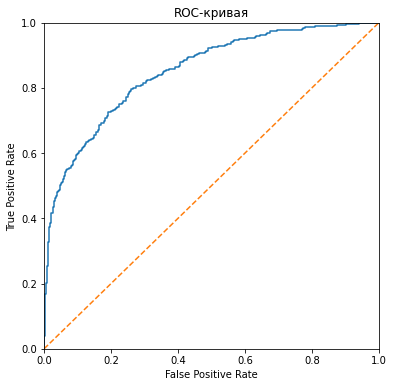

In [23]:
fpr, tpr, thresholds = roc_curve(y_test,  model_forest.predict_proba(X_test)[:, 1])
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Модель отличается от случайных предсказаний, но всё же предоставленных данных для высокоточного предсказания используемыми методами не достаточно.

Посмотрим, чего можно добиться, случайно предсказывая прекращение пользования услугами банка просто на основании распространённости данного события в выборке:

In [24]:
frequent_clf = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_predicted_by_frequency = frequent_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_predicted_by_frequency), 'F1:', f1_score(y_test, y_predicted_by_frequency))

accuracy: 0.7960417811984607 F1: 0.0


Несмотря на то, что accuracy нашей модели не существенно выше частоты распространения ключевого признака в выборке, мера F1 показывает, что в большинстве случаев модель предсказывает верно, есть экономический смысл пользовать ею при прогнозировании ухода клиента из банка.

## Вывод

Мы получили модель случайного леса, которая предсказывает уход клиента от банка на тестовой выборке с точностью 85%, мера F1 находится на уровне 0,62, что выше заданного порога в 0,59. Параметры наилучшей модели случайного леса следующие:
- n_estimators=210,
- max_depth=11,
- class_weight='balanced'.

Рабоая с этой моделью, можно предсказывать уход клиентов по тем же причинам, что это сделали пользователи, обладающие схожими характеристиками и практиками. Точность полученной модели не 100%, и можно говорить лишь о высокой вероятности ухода клиента, однако, обратив на него внимание банка, можно повысить лояльность данного клиента и потратить меньше средств на удержание данных групп пользователей, чем на привлечение новых клиентов.